# 1 Setup Paths¶

In [110]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.keras.utils import plot_m


import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import os

# Configuration and Hyperparameters

In [63]:
#входной размер изображений соответтсвует модели EfficiennetBo
IMG_SIZE = (224, 224)
TRAINING_DIR = "./data/train/"
VALIDATION_DIR = "./data/validation/"
CLASSES = ['bmw_x5', 'land_cruiser', 'qashqai', 'solyaris', 'vaz_2110']

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb
вставить описание контрольных точек
Let's start by creating the ModelCheckpoint callback.
Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [3]:

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Create checkpoint callback to save model for later use
CHECKPOINT_PATH = "./checkpoint/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True)

# Load Data

ImageDataGenerator...
Creating data loaders (preparing the data)
Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...


In [4]:
# Загружаем набор изображений с помощью ImageDataGenerator с применением аугментации для тренировочного набора.
training_datagen = ImageDataGenerator(rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',batch_size=32)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                target_size=IMG_SIZE,
                                                                class_mode='categorical',
                                                                shuffle=False,batch_size=32)

Found 130 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


In [5]:
# Переобразуем  валидационные данные из формата ImageDataGenerator в numpy массив. 
# это будет удобно для дальнейшего представления
images, labels = next(validation_datagen.flow_from_directory(VALIDATION_DIR,batch_size=45, shuffle=False))

Found 45 images belonging to 5 classes.


# Создание  и обучение модели

About EfficientNet Models
EfficientNets rely on AutoML and compound scaling to achieve superior performance without compromising resource efficiency. The AutoML Mobile framework has helped develop a mobile-size baseline network, EfficientNet-B0, which is then improved by the compound scaling method to obtain EfficientNet-B1 to B7.
https://github.com/qubvel/efficientnet
                                                                        картинку вставитьпжрзе

In [6]:
# Загрузим модель EfficientNetB0, предварительно обученную на наборе Imagenet,
# исключив полносвязный верхинй слой и заморозив для обучения остальные 
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

2022-03-30 19:37:25.457272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 19:37:25.482562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 19:37:25.482985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 19:37:25.484347: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
# Можем посмотреть состав модели и убедиться, что слои заморожены, а выход модели имеет размерность (None, 7, 7, 1280)
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [18]:
# Настройка архитектуры модели с обучаемыми верхними слоями
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # форма входного изображения
x = base_model(inputs, training=False) # поместим базовую модель в режим вывода, чтобы мы могли использовать ее для извлечения признаков без обновления весов
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # объединить результаты базовой модели
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [19]:
# Теперь наша модель выглядит так, обучаемых параметров получается в районе 6,5 тыс
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_____________________________________________

In [20]:
# Компиляция
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_generator,
                                           epochs=40, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

Epoch 1/40
5/5 [==============================] - 6s 630ms/step - loss: 1.6274 - accuracy: 0.2846 - val_loss: 1.5174 - val_accuracy: 0.4222
Epoch 2/40
5/5 [==============================] - 2s 440ms/step - loss: 1.4619 - accuracy: 0.4308 - val_loss: 1.4331 - val_accuracy: 0.4444
Epoch 3/40
5/5 [==============================] - 2s 447ms/step - loss: 1.3346 - accuracy: 0.5154 - val_loss: 1.3592 - val_accuracy: 0.5111
Epoch 4/40
5/5 [==============================] - 2s 440ms/step - loss: 1.3267 - accuracy: 0.5385 - val_loss: 1.2821 - val_accuracy: 0.6222
Epoch 5/40
5/5 [==============================] - 2s 446ms/step - loss: 1.2398 - accuracy: 0.5154 - val_loss: 1.2091 - val_accuracy: 0.6889
Epoch 6/40
5/5 [==============================] - 2s 501ms/step - loss: 1.1643 - accuracy: 0.5385 - val_loss: 1.1487 - val_accuracy: 0.7333
Epoch 7/40
5/5 [==============================] - 2s 436ms/step - loss: 1.0583 - accuracy: 0.6769 - val_loss: 1.0963 - val_accuracy: 0.7111
Epoch 8/40
5/5 [====

In [21]:
# Загрузим веса модели с лучшими показателями val_accuracy так
model.load_weights(CHECKPOINT_PATH)

In [119]:
# Оценка модели на валидационном наборе данных
results_feature_extraction_model = model.evaluate(validation_generator)
results_feature_extraction_model

2/2 [==============================] - 0s 31ms/step - loss: 0.2135 - accuracy: 0.9333


[0.21350961923599243, 0.9333333373069763]

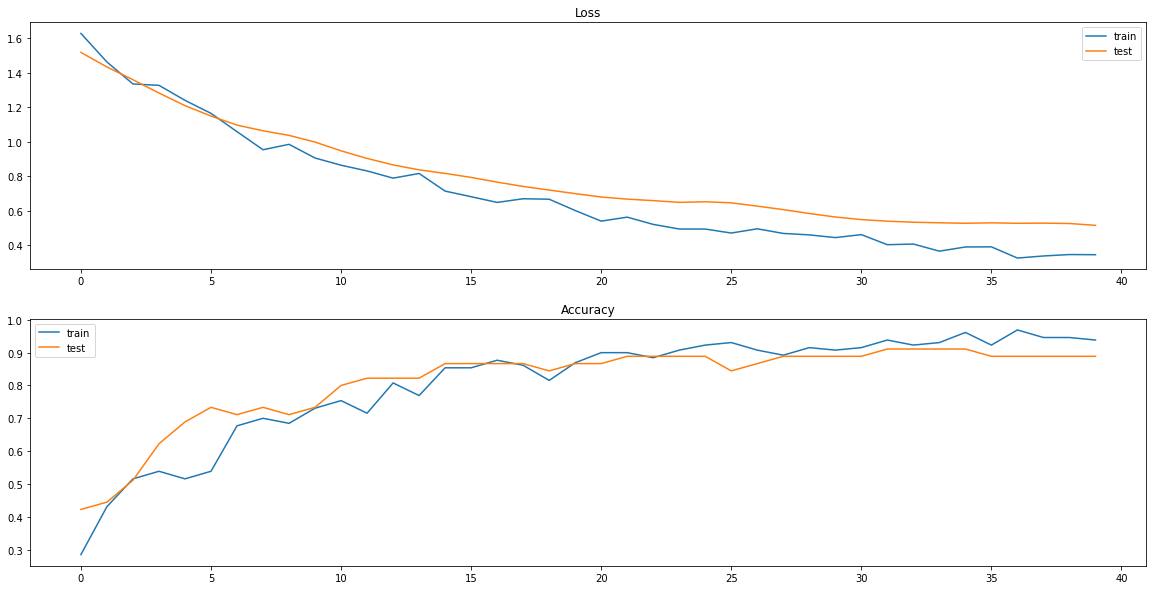

In [23]:
# График потерь во время обучения
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# График точности во время обучения
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Результаты достаточно неплохие, accuracy выходит на плато  в районе 0,85-0,95, так же можно выделить 
незначительное переобучнение, но мы хотим лучших результатов по этому переходим дальше

# Тонкая настройка

In [24]:
#Описать фан тюнинг из курса

In [26]:
# Оставим замороженными все слои кроме последних 10, их мы попытаемся обучить вместе с нашей моделью
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [30]:
# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_unfreez = tf.keras.Model(inputs, outputs)

In [31]:
# Вывод модели показывает, что количество обучаемых параметров выросло с 6,5 до 900 тыс. 
# за счет разморозки слоев efficientnetb0
model_unfreez.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 899,637
Non-trainable params: 3,156,339
___________________________________________

In [32]:

# Compile
model_unfreez.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_unfreez = model_unfreez.fit(train_generator,
                                           epochs=30, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

Epoch 1/30
5/5 [==============================] - 6s 618ms/step - loss: 1.4268 - accuracy: 0.3846 - val_loss: 1.0006 - val_accuracy: 0.4889
Epoch 2/30
5/5 [==============================] - 2s 495ms/step - loss: 0.8549 - accuracy: 0.7538 - val_loss: 0.5973 - val_accuracy: 0.8667
Epoch 3/30
5/5 [==============================] - 2s 445ms/step - loss: 0.4775 - accuracy: 0.9231 - val_loss: 0.4517 - val_accuracy: 0.8444
Epoch 4/30
5/5 [==============================] - 2s 447ms/step - loss: 0.3263 - accuracy: 0.9385 - val_loss: 0.4110 - val_accuracy: 0.8222
Epoch 5/30
5/5 [==============================] - 2s 446ms/step - loss: 0.2782 - accuracy: 0.9462 - val_loss: 0.3604 - val_accuracy: 0.8444
Epoch 6/30
5/5 [==============================] - 2s 433ms/step - loss: 0.1678 - accuracy: 0.9692 - val_loss: 0.2779 - val_accuracy: 0.8889
Epoch 7/30
5/5 [==============================] - 2s 448ms/step - loss: 0.1494 - accuracy: 0.9846 - val_loss: 0.3859 - val_accuracy: 0.8444
Epoch 8/30
5/5 [====

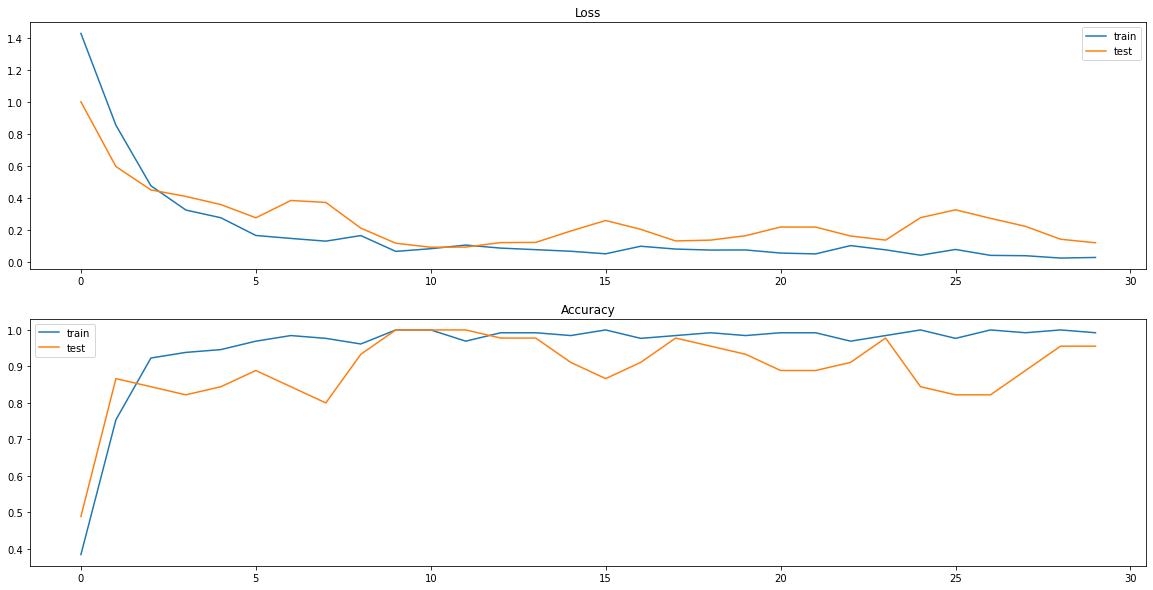

In [33]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history_unfreez.history['loss'], label='train')
plt.plot(history_unfreez.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history_unfreez.history['accuracy'], label='train')
plt.plot(history_unfreez.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Точность равную 1 мы получили буквально через 10 эпох обучения, далее мы наблюдаем  нестабильные показатели
loss и accuracy на валидационных данных, что может быть вызвано эффектом переобучения, но мы невилируем 
переобученность  модели с помощью загрузки весов полученных при лучшем val_accuracy.

In [34]:
#загрузим веса модели с наилучшими параметрами val_accuracy за период обучения
model_unfreez.load_weights(CHECKPOINT_PATH)

In [113]:
# Оценка модели на валидационном наборе данных
results_all_fine_tune = model_unfreez.evaluate(validation_generator)
results_all_fine_tune

2/2 [==============================] - 0s 32ms/step - loss: 0.1195 - accuracy: 1.0000


[0.11949814856052399, 1.0]

# Оценка модели

In [ ]:
tensorboard вставить описание  о нем

In [38]:
!tensorboard --logdir logs/fit

2022-03-30 20:13:57.768753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 20:13:57.778086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 20:13:57.778554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL

В tensorboard так же можно смотреть на графики обучения, причем совмещать несколько обучений за раз
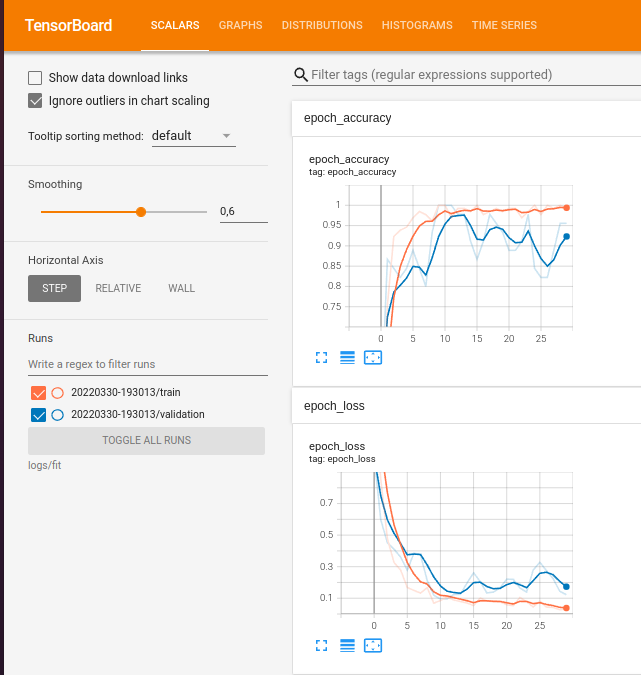

В tensorboard буквально можно наблюдать как обучались элементы вашей модели на каждой эпохе, это очень может пригодиться при 
качественной оценке каждого слоя модели

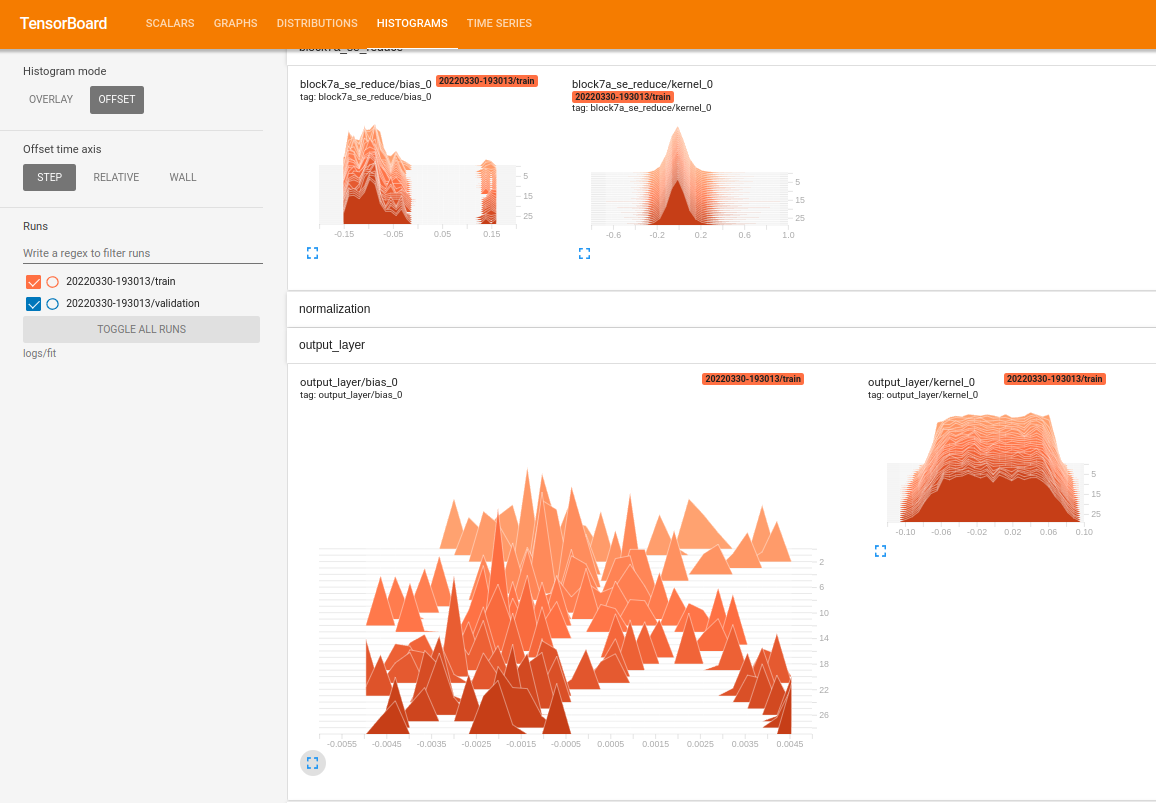

В тензорфлоу модель реализуется с помощью графа вычеслений, который автоматически строится и является неким черным ящиком, но благодаря чудесным функциям тенсорбоард мы можем его увидеть:)
# 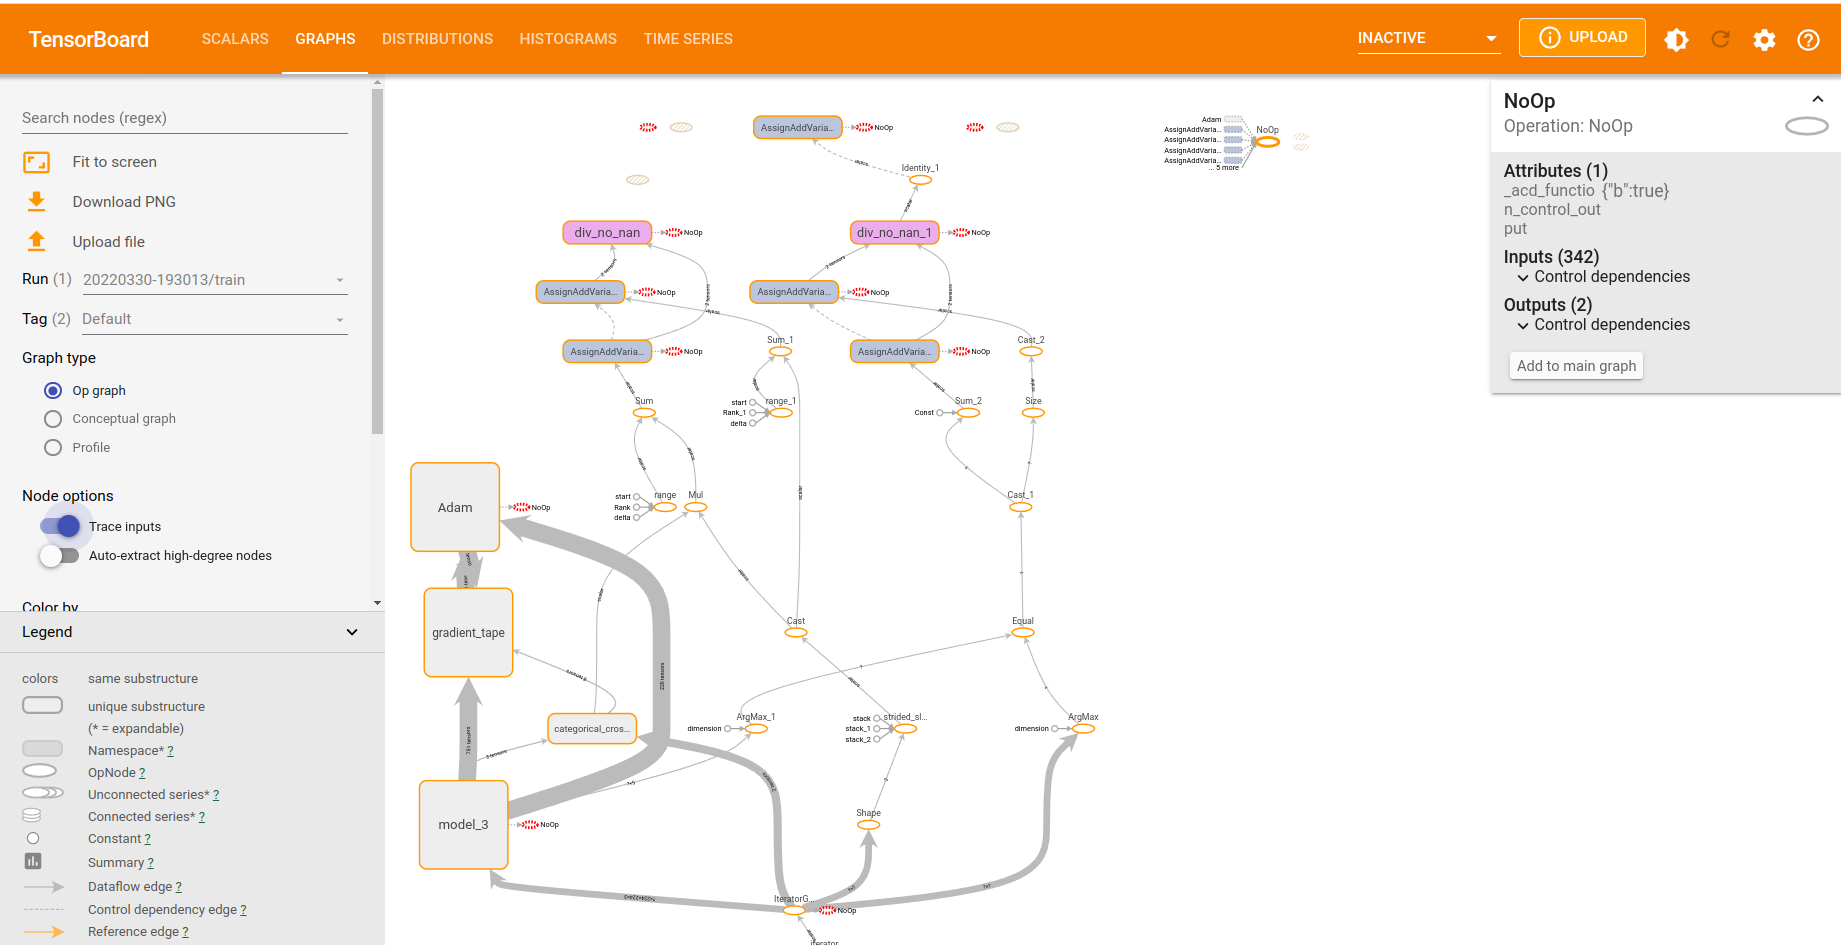


# Получение предсказаний

In [99]:
def read_img(link):
    img = cv2.imread(link)
    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # resize to 224x224 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224))
    return img

In [100]:
def predictions_img(link = './data/test/2110.jpeg'):
    # read the image
    img = read_img(link)
    # add a batch dimension in front
    image = np.expand_dims(img, axis=0)
    predictions = model_unfreez.predict(image, verbose=1)
    return predictions

In [101]:
#При использовании функции актвации softmax на выходе модели получаем вектор из действительных чисел [0,1] 
predictions = predictions_img('./data/test/l3.jpeg')
predictions

1/1 [==============================] - 0s 18ms/step


array([[1.1316540e-02, 9.5565981e-01, 5.1474804e-04, 7.8822090e-04,
        3.1720668e-02]], dtype=float32)

In [102]:
# Трансформируем векторное представление в предсказанный класс
predict_class = CLASSES[np.argmax(predictions)]
predict_class

'land_cruiser'

In [104]:
# Ну и собственно исходное изображение с предсказанием
def show(link='./data/test/l3.jpeg'):
    img = cv2.imread(link)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(predict_class)
    plt.show()

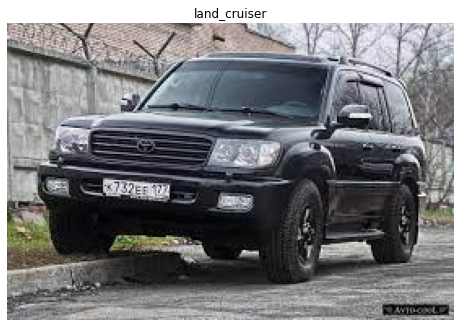

In [105]:
show('./data/test/l3.jpeg')

#  Корреляционная матрица

Вставить описание о кореляционнй матрице

In [111]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=5, norm=False, savefig=False): 
    y_pred = np.argmax(y_pred, axis=1)
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
  # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [117]:
pred_probs_confm = model_unfreez.predict(validation_generator, verbose=1)

2/2 [==============================] - 1s 60ms/step


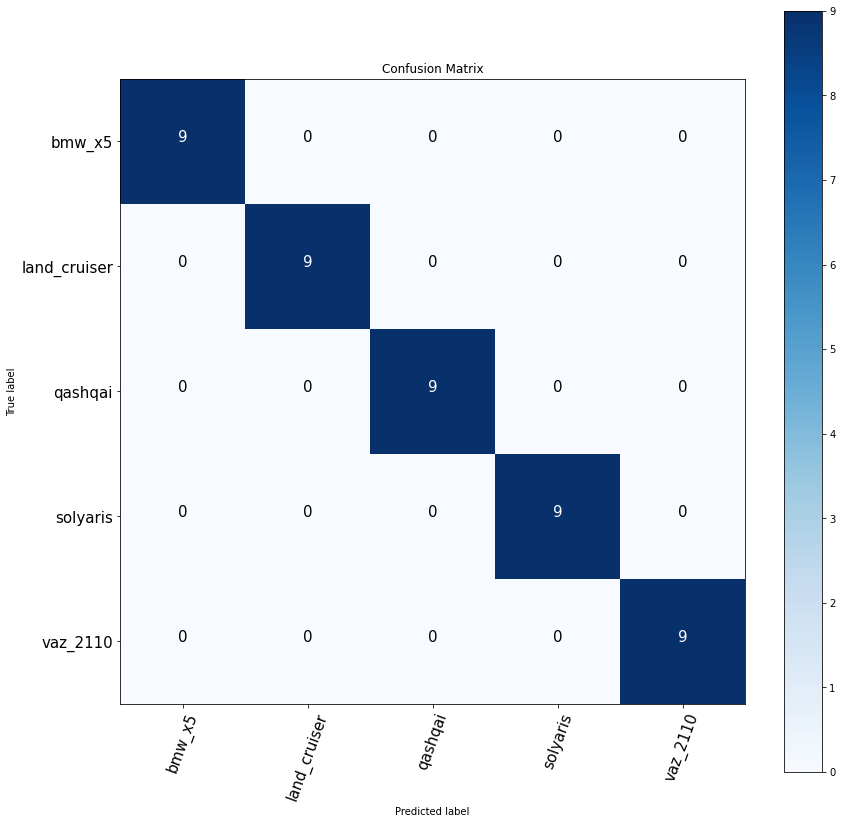

In [118]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=np.argmax(labels, axis=1),
                      y_pred=pred_probs_confm,
                      classes=CLASSES,
                      figsize=(14, 14),
                      text_size=15,
                      norm=False,
                      savefig=True)

С учетом того, что точность нашей модели равна 1 мы видим идеальный вариант кореляционной матрицы

# Saliency map

Еще один из вариантов оценить как работает наша модель ... (вставить из статьи)

In [120]:
# Чтение изображения в numpy массив  размерностью (1, 224, 224, 3) и (224, 224, 3)
def read_img_expand(link):
    # read the image
    img = cv2.imread(link)

    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # resize to 300x300 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224)) 

    # add a batch dimension in front
    image_expand = np.expand_dims(img, axis=0)
    return image_expand, img

In [123]:
# class ID
class_index = 1   




# number of classes in the model's training data
num_classes = 5
image_expand, img = read_img_expand(link='./data/test/l4.jpeg')
# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image_expand.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image_expand, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model_unfreez(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [124]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

In [ ]:
# # max and min value in the grayscale tensor
# print(np.max(grayscale_tensor[0]))
# print(np.min(grayscale_tensor[0]))
# print()

# # coordinates of the first pixel where the max and min values are located
# max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
# min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
# print(max_pixel)
# print(min_pixel)
# print()

# # these coordinates should have the max (255) and min (0) value in the normalized tensor
# print(normalized_tensor[max_pixel])
# print(normalized_tensor[min_pixel])

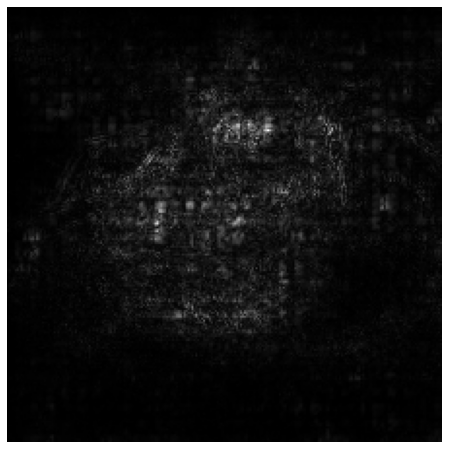

In [128]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()


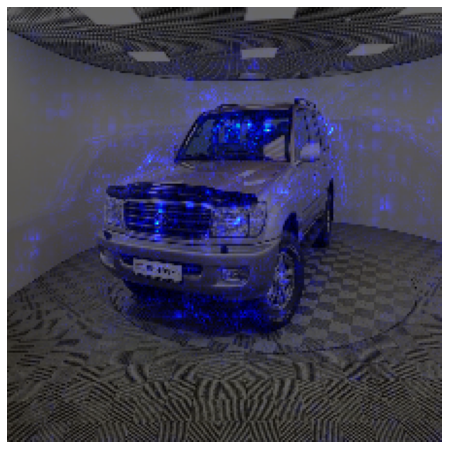

In [126]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color 
super_imposed = cv2.addWeighted(img, 0.4, gradient_color, 0.8, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

# Сохранение модели

In [133]:
# Save the entire model as a models/model/1
MODEL_DIR = "models"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = models/1

INFO:tensorflow:Assets written to: models/1/assets


/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
